In [67]:
import kitti_loader as kloader
import data

train = kloader.generate_dataframe("./splits/kitti_train.csv", "train")
test = kloader.generate_dataframe("./splits/kitti_test.csv", "val")

train_generator = data.DataGenerator(train, datatype="kitti")
test_generator = data.DataGenerator(test, datatype="kitti")

In [2]:
images, depth = test_generator.__getitem__(1)

2022-05-10 20:29:05.726144: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-10 20:29:05.727318: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-10 20:29:07.423298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-10 20:29:07.425161: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:22:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-10 20:29:07.426988: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:41:00.0 name: Tesl

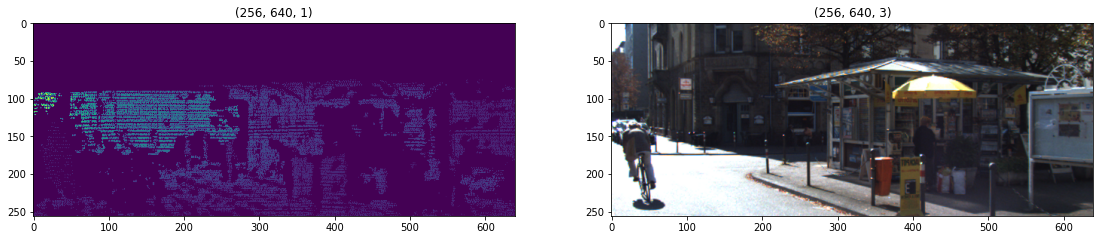

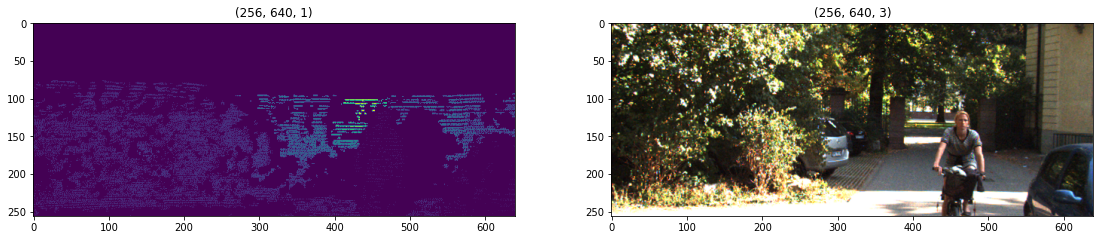

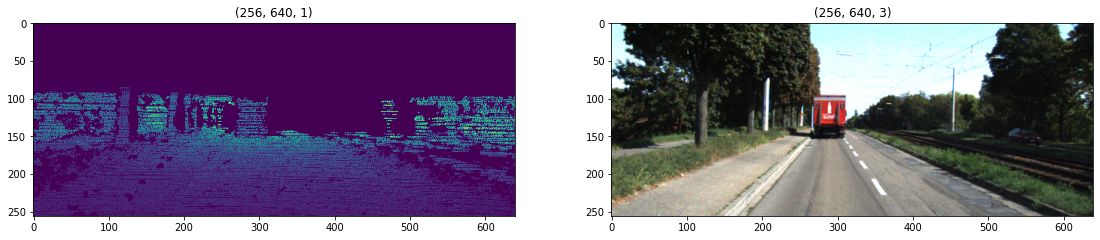

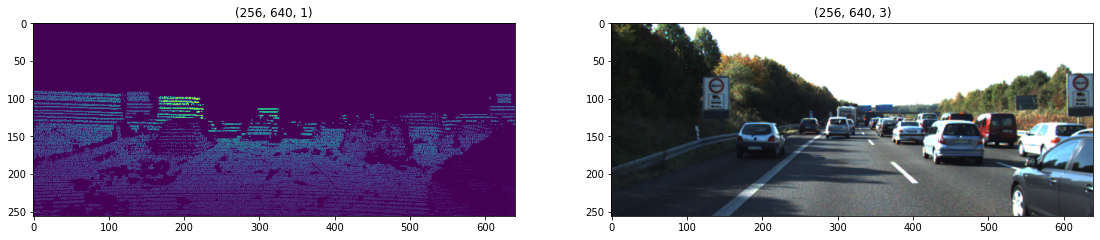

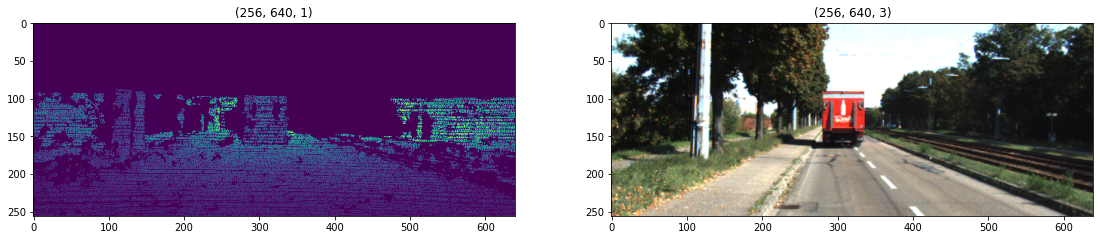

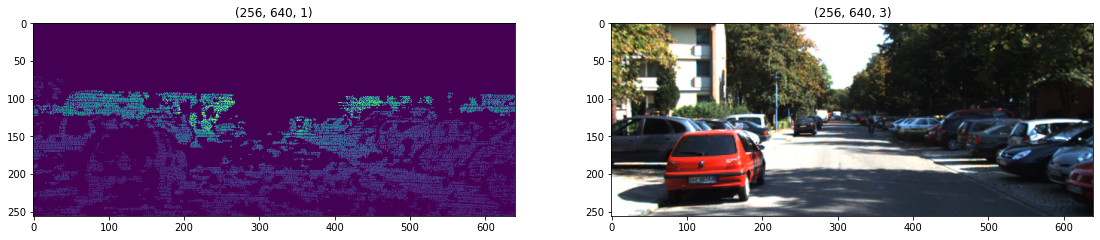

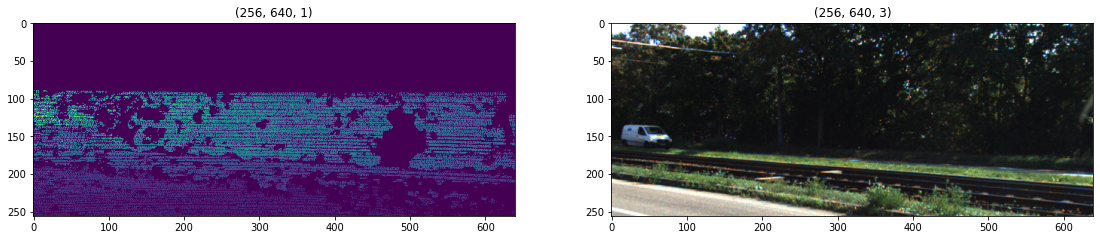

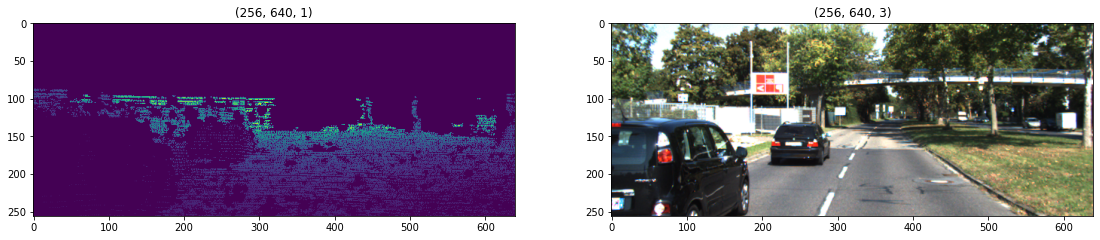

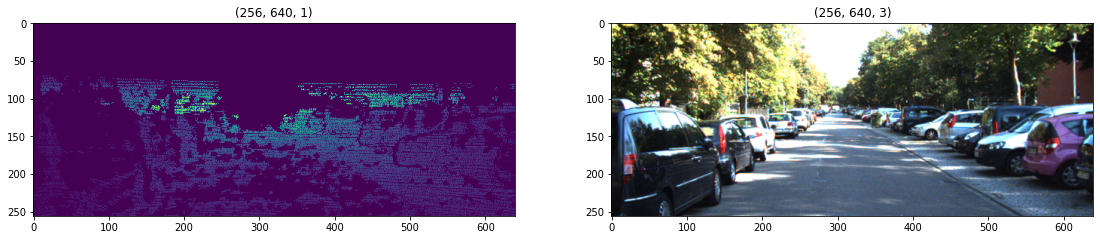

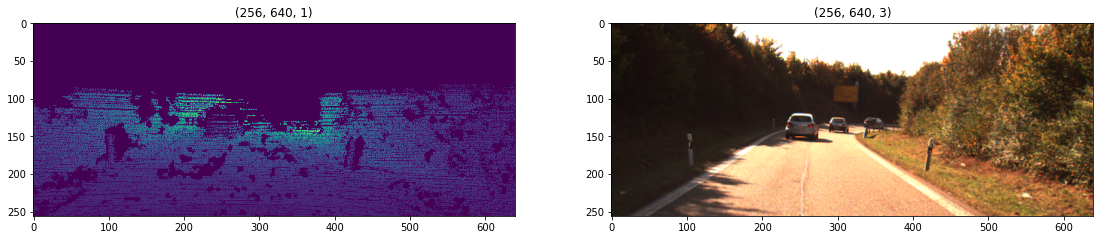

In [3]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.figure(figsize=(19,10))
    plt.subplot(1,2,1)
    plt.title(depth[i].shape)
    plt.imshow(depth[i])
    plt.subplot(1,2,2)
    plt.title(images[i].shape)
    plt.imshow(images[i])

In [23]:
# Original Matlab code https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html
#
#
# Python port of depth filling code from NYU toolbox
# Speed needs to be improved
#
# Uses 'pypardiso' solver 
#
import skimage
import scipy
import numpy as np
from scipy.sparse.linalg import spsolve
from PIL import Image

#
# fill_depth_colorization.m
# Preprocesses the kinect depth image using a gray scale version of the
# RGB image as a weighting for the smoothing. This code is a slight
# adaptation of Anat Levin's colorization code:
#
# See: www.cs.huji.ac.il/~yweiss/Colorization/
#
# Args:
#  imgRgb - HxWx3 matrix, the rgb image for the current frame. This must
#      be between 0 and 1.
#  imgDepth - HxW matrix, the depth image for the current frame in
#       absolute (meters) space.
#  alpha - a penalty value between 0 and 1 for the current depth values.

def fill_depth_colorization(imgRgb=None, imgDepthInput=None, alpha=1):
    imgIsNoise = imgDepthInput == 0
    maxImgAbsDepth = np.max(imgDepthInput)
    imgDepth = imgDepthInput / maxImgAbsDepth
    imgDepth[imgDepth > 1] = 1
    (H, W) = imgDepth.shape
    numPix = H * W
    indsM = np.arange(numPix).reshape((W, H)).transpose()
    knownValMask = (imgIsNoise == False).astype(int)
    grayImg = skimage.color.rgb2gray(imgRgb)
    winRad = 1
    len_ = 0
    absImgNdx = 0
    len_window = (2 * winRad + 1) ** 2
    len_zeros = numPix * len_window

    cols = np.zeros(len_zeros) - 1
    rows = np.zeros(len_zeros) - 1
    vals = np.zeros(len_zeros) - 1
    gvals = np.zeros(len_window) - 1

    for j in range(W):
        for i in range(H):
            nWin = 0
            for ii in range(max(0, i - winRad), min(i + winRad + 1, H)):
                for jj in range(max(0, j - winRad), min(j + winRad + 1, W)):
                    if ii == i and jj == j:
                        continue

                    rows[len_] = absImgNdx
                    cols[len_] = indsM[ii, jj]
                    gvals[nWin] = grayImg[ii, jj]

                    len_ = len_ + 1
                    nWin = nWin + 1

            curVal = grayImg[i, j]
            gvals[nWin] = curVal
            c_var = np.mean((gvals[:nWin + 1] - np.mean(gvals[:nWin+ 1])) ** 2)

            csig = c_var * 0.6
            mgv = np.min((gvals[:nWin] - curVal) ** 2)
            if csig < -mgv / np.log(0.01):
                csig = -mgv / np.log(0.01)

            if csig < 2e-06:
                csig = 2e-06

            gvals[:nWin] = np.exp(-(gvals[:nWin] - curVal) ** 2 / csig)
            gvals[:nWin] = gvals[:nWin] / sum(gvals[:nWin])
            vals[len_ - nWin:len_] = -gvals[:nWin]

            # Now the self-reference (along the diagonal).
            rows[len_] = absImgNdx
            cols[len_] = absImgNdx
            vals[len_] = 1  # sum(gvals(1:nWin))

            len_ = len_ + 1
            absImgNdx = absImgNdx + 1

    vals = vals[:len_]
    cols = cols[:len_]
    rows = rows[:len_]
    A = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

    rows = np.arange(0, numPix)
    cols = np.arange(0, numPix)
    vals = (knownValMask * alpha).transpose().reshape(numPix)
    G = scipy.sparse.csr_matrix((vals, (rows, cols)), (numPix, numPix))

    A = A + G
    b = np.multiply(vals.reshape(numPix), imgDepth.flatten('F'))

    #print ('Solving system..')

    new_vals = spsolve(A, b)
    new_vals = np.reshape(new_vals, (H, W), 'F')

    #print ('Done.')

    denoisedDepthImg = new_vals * maxImgAbsDepth

    output = denoisedDepthImg.reshape((H, W)).astype('float32')

    output = np.multiply(output, (1-knownValMask)) + imgDepthInput

    return output

In [24]:
images[0]

array([[[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.45490196, 0.49411765, 0.12156863],
        [0.73333335, 0.75686276, 0.5058824 ],
        [0.2901961 , 0.61960787, 0.58431375]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.21176471, 0.28627452, 0.8235294 ],
        [0.2627451 , 0.34509805, 0.39215687],
        [0.15294118, 0.23529412, 0.32156864]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.23529412, 0.6901961 , 1.        ],
        [0.23529412, 0.33333334, 0.28627452],
        [0.13725491, 0.18039216, 0.15294118]],

       ...,

       [[0.1254902 , 0.16862746, 0.15294118],
        [0.16862746, 0.19215687, 0.15294118],
        [0.1764706 , 0

In [5]:
import cv2
import time
import numpy as np
import scripts.kitti_correct_gray as kitti_correction

print(images[0].shape)

# img = cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)
start_time = time.time()
r = kitti_correction.fill_depth_colorization(images[1], np.squeeze(depth[1]))
print(time.time() - start_time)

(256, 640, 3)
16.922049283981323


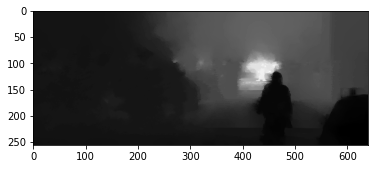

In [6]:
plt.imshow(r, cmap="gray")

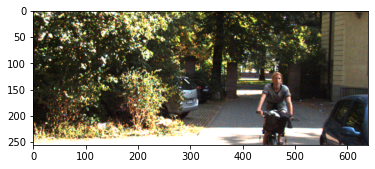

In [7]:
plt.imshow(images[1], cmap="gray")

In [8]:
r.shape

(256, 640)

In [9]:
r

array([[0.12747745, 0.12747745, 0.12747771, ..., 0.2937057 , 0.29370514,
        0.29369029],
       [0.12747745, 0.12747745, 0.12747747, ..., 0.29370597, 0.29370421,
        0.29368988],
       [0.12747729, 0.12747738, 0.12747738, ..., 0.29369965, 0.29369885,
        0.29361001],
       ...,
       [0.10671458, 0.10671292, 0.10672592, ..., 0.05333443, 0.05333443,
        0.05333439],
       [0.10671476, 0.10671598, 0.10666667, ..., 0.05333446, 0.05333443,
        0.05333442],
       [0.10671527, 0.10671507, 0.10672886, ..., 0.05333535, 0.05333446,
        0.05333442]])

In [33]:
import cv2
path = "/data3/awong/kitti/train/"
img = cv2.imread(path + "2011_09_30_drive_0018_sync/proj_depth/correctedTruth/image_02/0000000671.png", cv2.IMREAD_GRAYSCALE)
img.shape

(370, 1226)

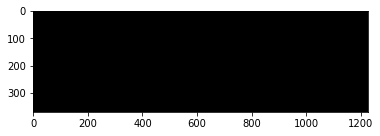

In [34]:
import matplotlib.pyplot as plt
plt.imshow(img, cmap='gray')

In [53]:
from PIL import Image
import cv2

def load_color_image(filename, **kwargs):
#     img = Image.open(filename)
#     return np.array(img)
    img = cv2.imread(filename)
    return img

def load_depth_image(filename, **kwargs):
#     img = Image.open(filename).convert('L')
#     return np.array(img)
    depth = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    return depth

In [54]:
image_path = "/data3/awong/kitti_raw/2011_09_30/2011_09_30_drive_0018_sync/image_02/data/0000000671.png"
depth_path = "/data3/awong/kitti/train/2011_09_30_drive_0018_sync/proj_depth/groundtruth/image_02/0000000671.png"

In [55]:
img = load_color_image(image_path)
print(img.shape)
img = (img - img.min()) / (img.max() - img.min())

d = load_depth_image(depth_path)
d = (d - d.min()) / (d.max() - d.min())
print(d.shape)

(370, 1226, 3)
(370, 1226)


In [56]:
result = kitti_correction.fill_depth_colorization(img, np.squeeze(d))

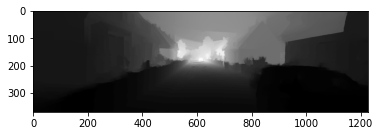

In [57]:
import matplotlib.pyplot as plt
plt.imshow(result, cmap='gray')

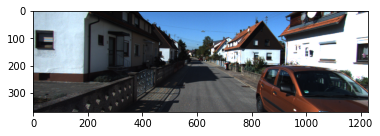

In [41]:
plt.imshow(img)

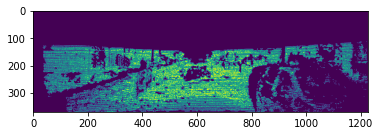

In [42]:
plt.imshow(d)

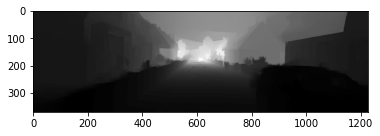

In [69]:
import cv2
img = cv2.imread("/data3/awong/kitti/train/2011_09_30_drive_0018_sync/proj_depth/correctedtruth/image_02/0000000671.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

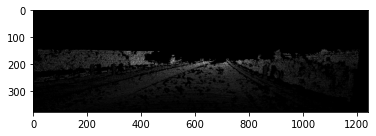

In [65]:
depth1 = cv2.imread("/data3/awong/kitti/train/2011_10_03_drive_0042_sync/proj_depth/groundtruth/image_03/0000000973.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

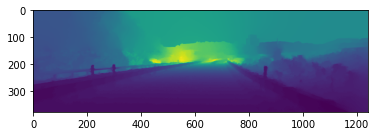

In [66]:
img1 = cv2.imread("/data3/awong/kitti_raw/2011_10_03/2011_10_03_drive_0042_sync/image_03/data/0000000973.png")
result = kitti_correction.fill_depth_colorization(img1, np.squeeze(depth1))
plt.imshow(result)

In [68]:
train[:10]

images  \
0  2011_09_30/2011_09_30_drive_0018_sync/image_03...   
1  2011_09_30/2011_09_30_drive_0033_sync/image_03...   
2  2011_09_26/2011_09_26_drive_0086_sync/image_03...   
3  2011_09_28/2011_09_28_drive_0039_sync/image_03...   
4  2011_09_28/2011_09_28_drive_0090_sync/image_03...   
5  2011_09_30/2011_09_30_drive_0028_sync/image_03...   
6  2011_09_30/2011_09_30_drive_0018_sync/image_02...   
7  2011_09_26/2011_09_26_drive_0093_sync/image_03...   
8  2011_10_03/2011_10_03_drive_0034_sync/image_02...   
9  2011_09_30/2011_09_30_drive_0028_sync/image_03...   

                                               depth  
0  train/2011_09_30_drive_0018_sync/proj_depth/gr...  
1  train/2011_09_30_drive_0033_sync/proj_depth/gr...  
2  train/2011_09_26_drive_0086_sync/proj_depth/gr...  
3  train/2011_09_28_drive_0039_sync/proj_depth/gr...  
4  train/2011_09_28_drive_0090_sync/proj_depth/gr...  
5  train/2011_09_30_drive_0028_sync/proj_depth/gr...  
6  train/2011_09_30_drive_0018_sync/proj_depth/gr...  
7  train/2011_09_26_drive_0093_sync/proj_depth/gr...  
8  train/2011_10_03_drive_0034_sync/proj_depth/gr...  
9  train/2011_09_30_drive_0028_sync/proj_depth/gr...

(768, 1024, 3)


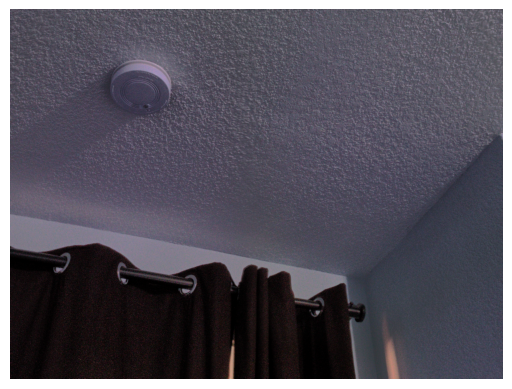

In [1]:
import cv2
import matplotlib.pyplot as plt
plt.axis('off')

image = "00000_00000_indoors_240_050.png"   
depth = image[:-4] + "_depth.npy" 
depth_mask = image[:-4] + "_depth_mask.npy"

img = cv2.imread(f"/data3/awong/diode/train/indoors/scene_00000/scan_00000/{image}")
print(img.shape)
plt.imshow(img)

In [2]:
import numpy as np

depth_map = f"/data3/awong/diode/train/indoors/scene_00000/scan_00000/{depth}"
mask = f"/data3/awong/diode/train/indoors/scene_00000/scan_00000/{depth_mask}"

depth_map = np.load(depth_map).squeeze()

mask = np.load(mask)
mask = mask > 0

max_depth = min(300, np.percentile(depth_map, 99))
depth_map = np.clip(depth_map, 0.1, max_depth)
depth_map = np.log(depth_map, where=mask)

depth_map = np.ma.masked_where(~mask, depth_map)

depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
depth_map = cv2.resize(depth_map, (1024, 768))
depth_map = np.expand_dims(depth_map, axis=2)
# depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)

(768, 1024, 1)


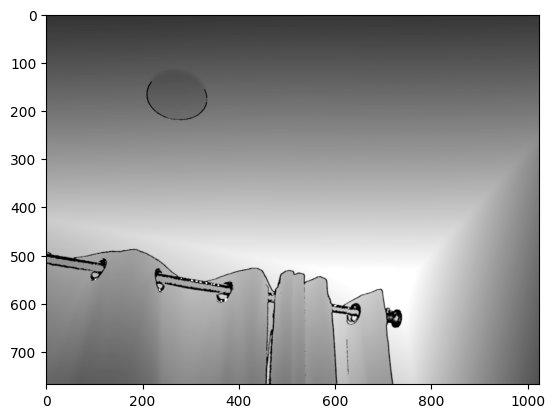

In [3]:
cmap = plt.cm.jet
cmap.set_bad(color="black")

print(depth_map.shape)
plt.imshow(depth_map, cmap='gray')

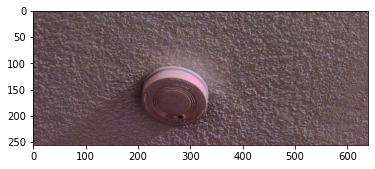

In [24]:
import diode_loader as dloader

img = dloader.load_color("train/indoors/scene_00000/scan_00000/" + image)
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img)

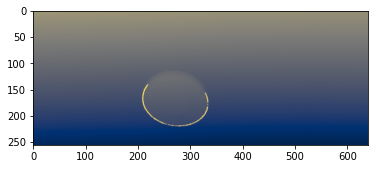

In [25]:
d = dloader.load_depth("train/indoors/scene_00000/scan_00000/" + depth, "train/indoors/scene_00000/scan_00000/" + depth_mask)
d = (d - d.min()) / (d.max() - d.min())
plt.imshow(d, cmap='cividis_r')